In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import yaml
from importlib import reload
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import pprint
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [38]:
!mkdir -p plots
!mkdir -p data
!mkdir -p transformers
!touch transformers/__init__.py
!mkdir -p classifiers
!touch classifiers/__init__.py
!mkdir -p experiments
!mkdir -p experiments/results

### Downloading the dataset


In [75]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_LUewxxVLY9qvkhvg-BnL2Yw1hrJSRLK' -O 'data/bank_loan.csv'

--2023-12-11 23:34:45--  https://docs.google.com/uc?export=download&id=1_LUewxxVLY9qvkhvg-BnL2Yw1hrJSRLK
Resolving docs.google.com (docs.google.com)... 142.250.184.174
Connecting to docs.google.com (docs.google.com)|142.250.184.174|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i2h9ajnp4af9jai85omho1ekp0ki9dbq/1702334025000/18373283666803574064/*/1_LUewxxVLY9qvkhvg-BnL2Yw1hrJSRLK?e=download&uuid=5ef6d431-39e4-4547-ba3b-159680ce11a7 [following]
--2023-12-11 23:34:46--  https://doc-0c-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i2h9ajnp4af9jai85omho1ekp0ki9dbq/1702334025000/18373283666803574064/*/1_LUewxxVLY9qvkhvg-BnL2Yw1hrJSRLK?e=download&uuid=5ef6d431-39e4-4547-ba3b-159680ce11a7
Resolving doc-0c-9s-docs.googleusercontent.com (doc-0c-9s-docs.googleusercontent.com)... 142.250.200.97
Connecting to doc-0c-9s-docs.googleusercontent

### Reading the dataset as a pandas DataFrame


In [15]:
loan_df = pd.read_csv('data/bank_loan.csv', low_memory=False, index_col='ID')
loan_df

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0


### Description of the dataset


In [77]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5000
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal Loan       5000 non-null   int64  
 9   Securities Account  5000 non-null   int64  
 10  CD Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 546.9 KB


In [78]:
loan_df.describe()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


### Adding yaml for dataset description


In [85]:
dataset_description = {
    'name': 'Bank Personal Loan Modelling',
    'url': 'https://www.kaggle.com/itsmesunil/bank-loan-modelling',
    'description': 'The data set includes 5000 observations with fourteen variables divided into four different measurement categories. The binary category has five variables, including the target variable personal loan, also securities account, CD account, online banking and credit card. The interval category contains five variables: age, experience, income, CC avg and mortgage. The ordinal category includes the variables family and education.',
    'row_count': loan_df.shape[0],
    'column_count': loan_df.shape[1],
    'columns': loan_df.columns.tolist(),
    'target_column': 'Personal Loan',
}

with open('data/bank_loan.description.yaml', 'w') as file:
    yaml.dump(dataset_description, file, sort_keys=False)

dataset_description

{'name': 'Bank Personal Loan Modelling',
 'url': 'https://www.kaggle.com/itsmesunil/bank-loan-modelling',
 'description': 'The data set includes 5000 observations with fourteen variables divided into four different measurement categories. The binary category has five variables, including the target variable personal loan, also securities account, CD account, online banking and credit card. The interval category contains five variables: age, experience, income, CC avg and mortgage. The ordinal category includes the variables family and education.',
 'row_count': 5000,
 'column_count': 14,
 'columns': ['Age',
  'Experience',
  'Income',
  'ZIP Code',
  'Family',
  'CCAvg',
  'Education',
  'Mortgage',
  'Personal Loan',
  'Securities Account',
  'CD Account',
  'Online',
  'CreditCard',
  'Has Mortgage'],
 'target_column': 'Personal Loan'}

### Adding Has Mortgage column to the dataset

Since Mortgage is 0 for most people, and a positive value for others, it ca be useful for analyzing the dataset to threat it as a boolean variable, for some plots and analysis.

This feature will be highly correlated with Mortgage, so it will probably be removed later before classification.


In [16]:
loan_df['Has Mortgage'] = loan_df['Mortgage'] > 0

### Distribution plots


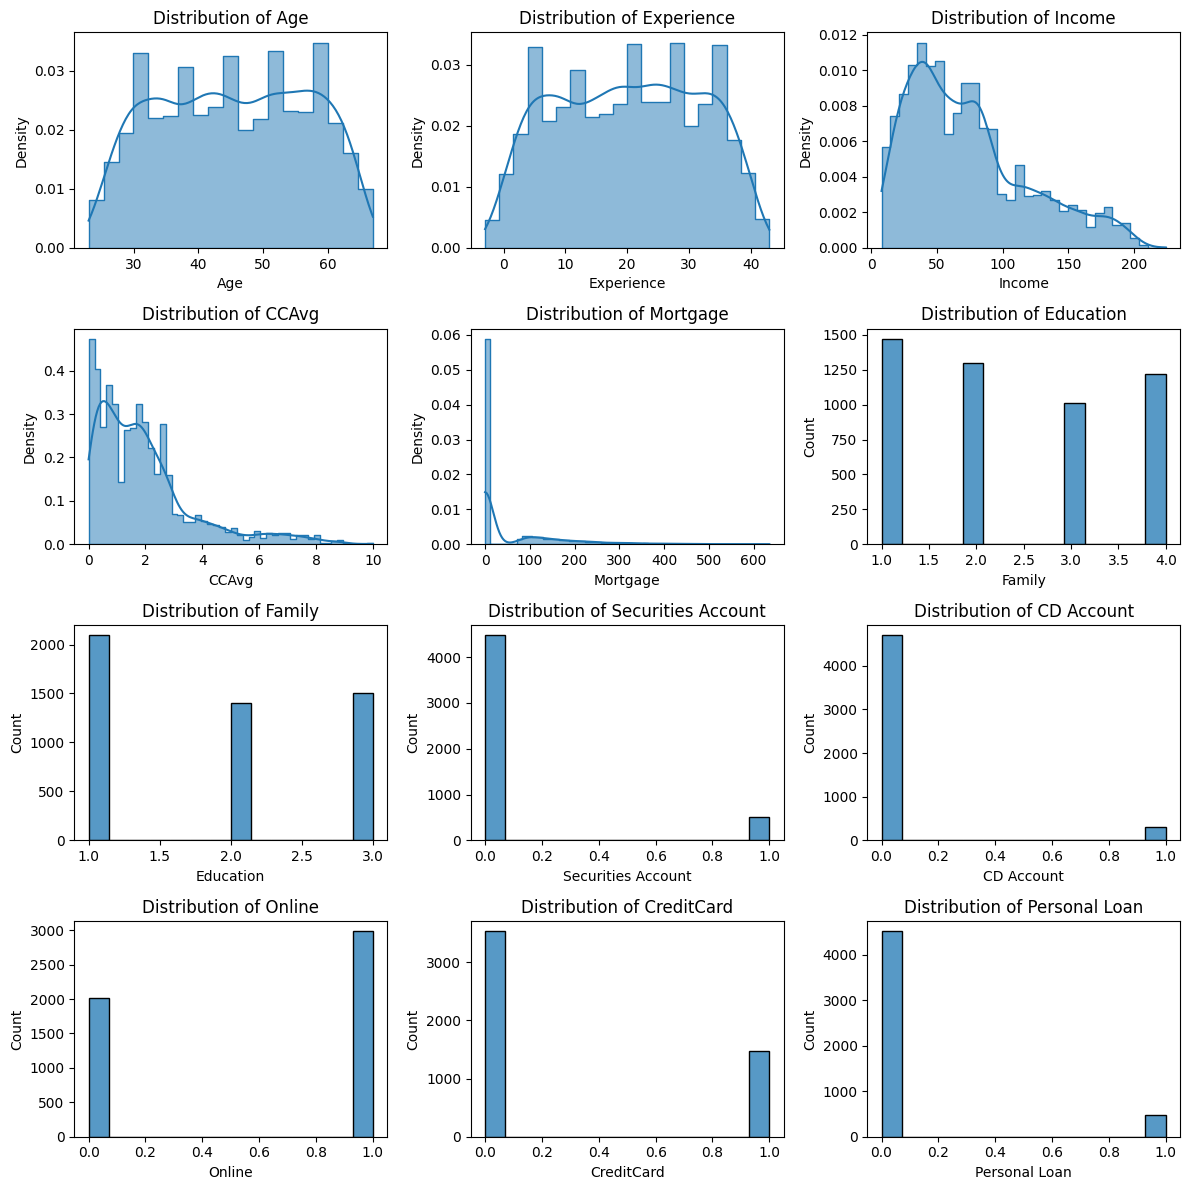

In [80]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

sns.histplot(data=loan_df, x='Age', kde=True, element='step', stat='density', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Age')

sns.histplot(data=loan_df, x='Experience', kde=True, element='step', stat='density', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Experience')

sns.histplot(data=loan_df, x='Income', kde=True, element='step', stat='density', ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Income')

sns.histplot(data=loan_df, x='CCAvg', kde=True, element='step', stat='density', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of CCAvg')

sns.histplot(data=loan_df, x='Mortgage', kde=True, element='step', stat='density', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Mortgage')

sns.histplot(data=loan_df, x='Family', ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Education')

sns.histplot(data=loan_df, x='Education', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Family')

sns.histplot(data=loan_df, x='Securities Account', ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Securities Account')

sns.histplot(data=loan_df, x='CD Account', ax=axes[2, 2])
axes[2, 2].set_title('Distribution of CD Account')

sns.histplot(data=loan_df, x='Online', ax=axes[3, 0])
axes[3, 0].set_title('Distribution of Online')

sns.histplot(data=loan_df, x='CreditCard', ax=axes[3, 1])
axes[3, 1].set_title('Distribution of CreditCard')

sns.histplot(data=loan_df, x='Personal Loan', ax=axes[3, 2])
axes[3, 2].set_title('Distribution of Personal Loan')

plt.tight_layout()

plt.savefig('plots/distributions.png')
plt.show()


Note that most of the customers did not take a Personal Loan, so the dataset is unbalanced, we will need to use later some techniques since most models work better if trained with balanced data.


### Pairplot


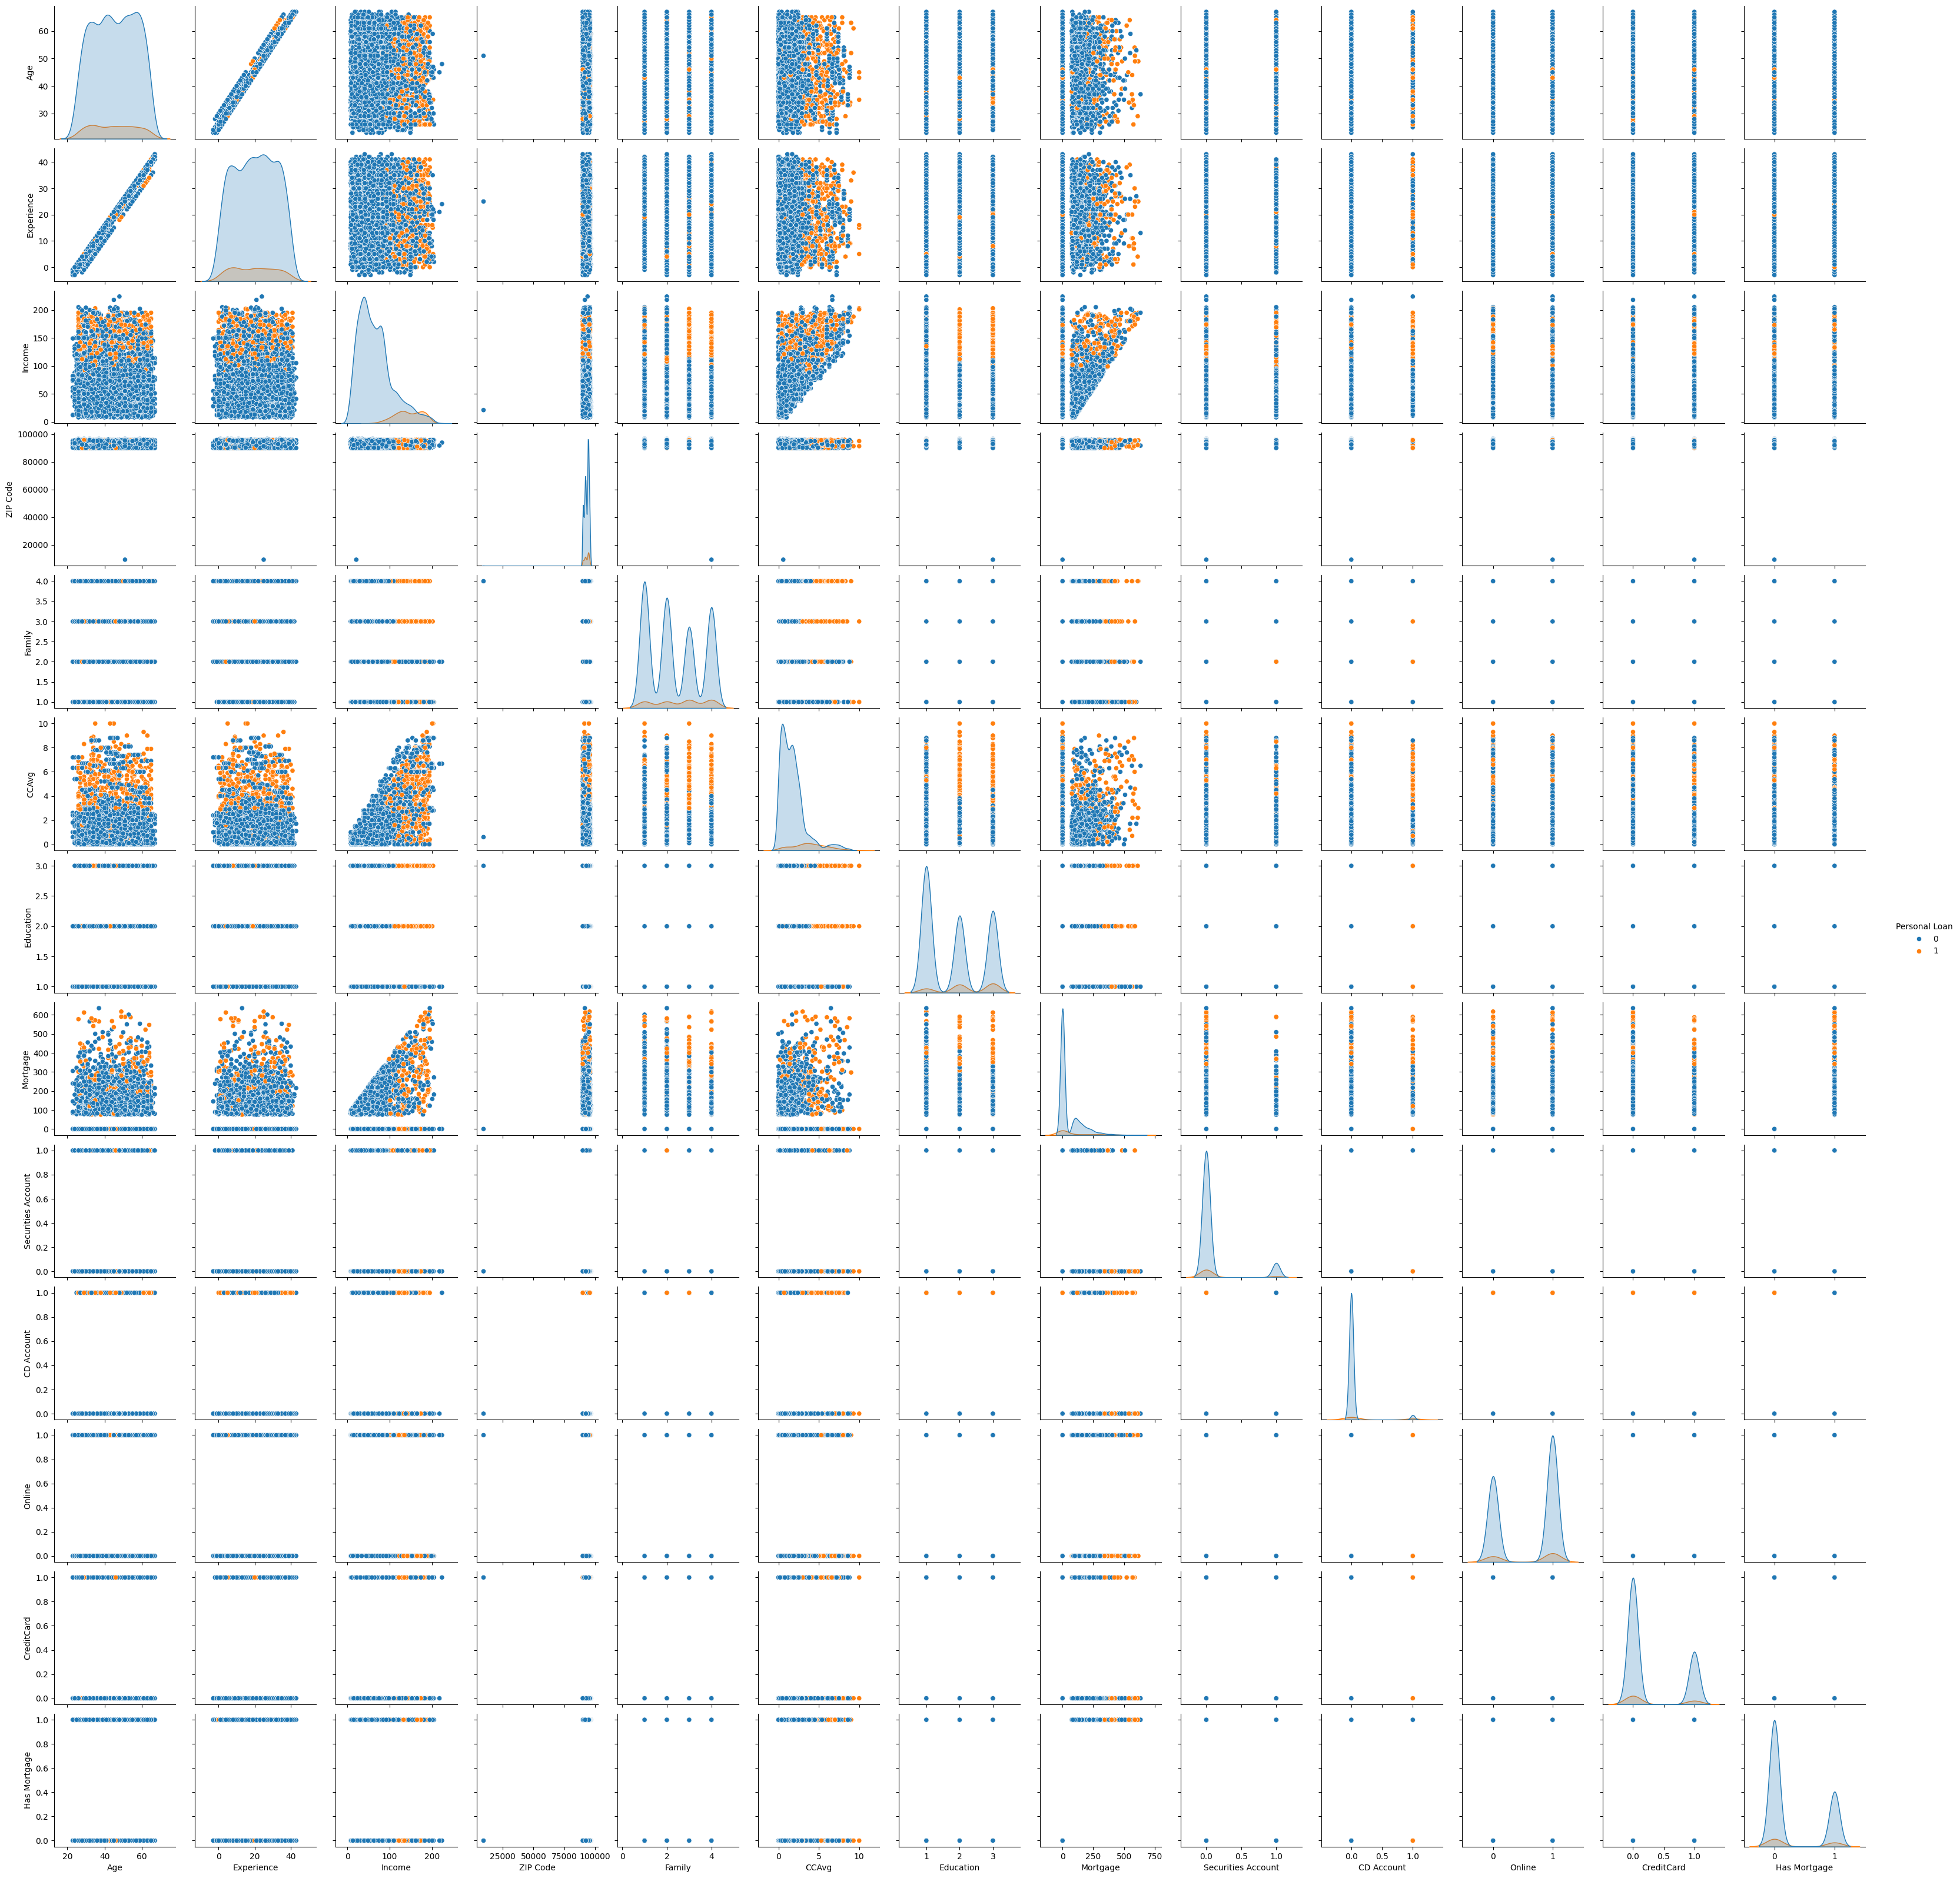

In [64]:
pairplot = sns.pairplot(loan_df, hue='Personal Loan')

pairplot.savefig('plots/pairplot.png')

### Correlation matrix of all features


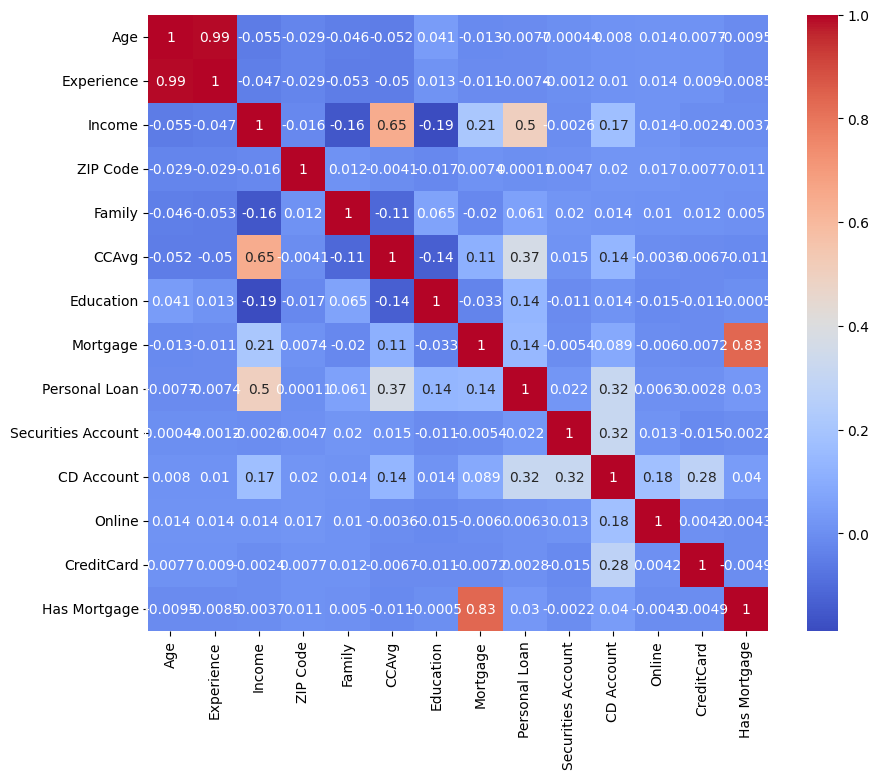

In [65]:
corr_matrix = loan_df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.savefig('plots/corr_matrix.png')
plt.show()

#### From correlation matrix, we can see:

- Age and experience are highly correlated, which makes sense since more age usually means more years of experience, due to their very high correlation, using both may be redundant and we may drop one of them.

- Income has 0.5 correlation to Personal Loan, which indicates that higher income customers are more likely to take a personal loan

- CC Avg and CD Account also have correlation with Personal Loan, which suggests that customers with higher average credit card spending or customers with certificate of deposit amount are more likely to take a personal loan

- Mortgage and Has Mortgage have high correlation, which is expected, we can also see that Mortgage itself has more correlation with Personal Loan than Has Mortgage


#### Box Plots of numerical features


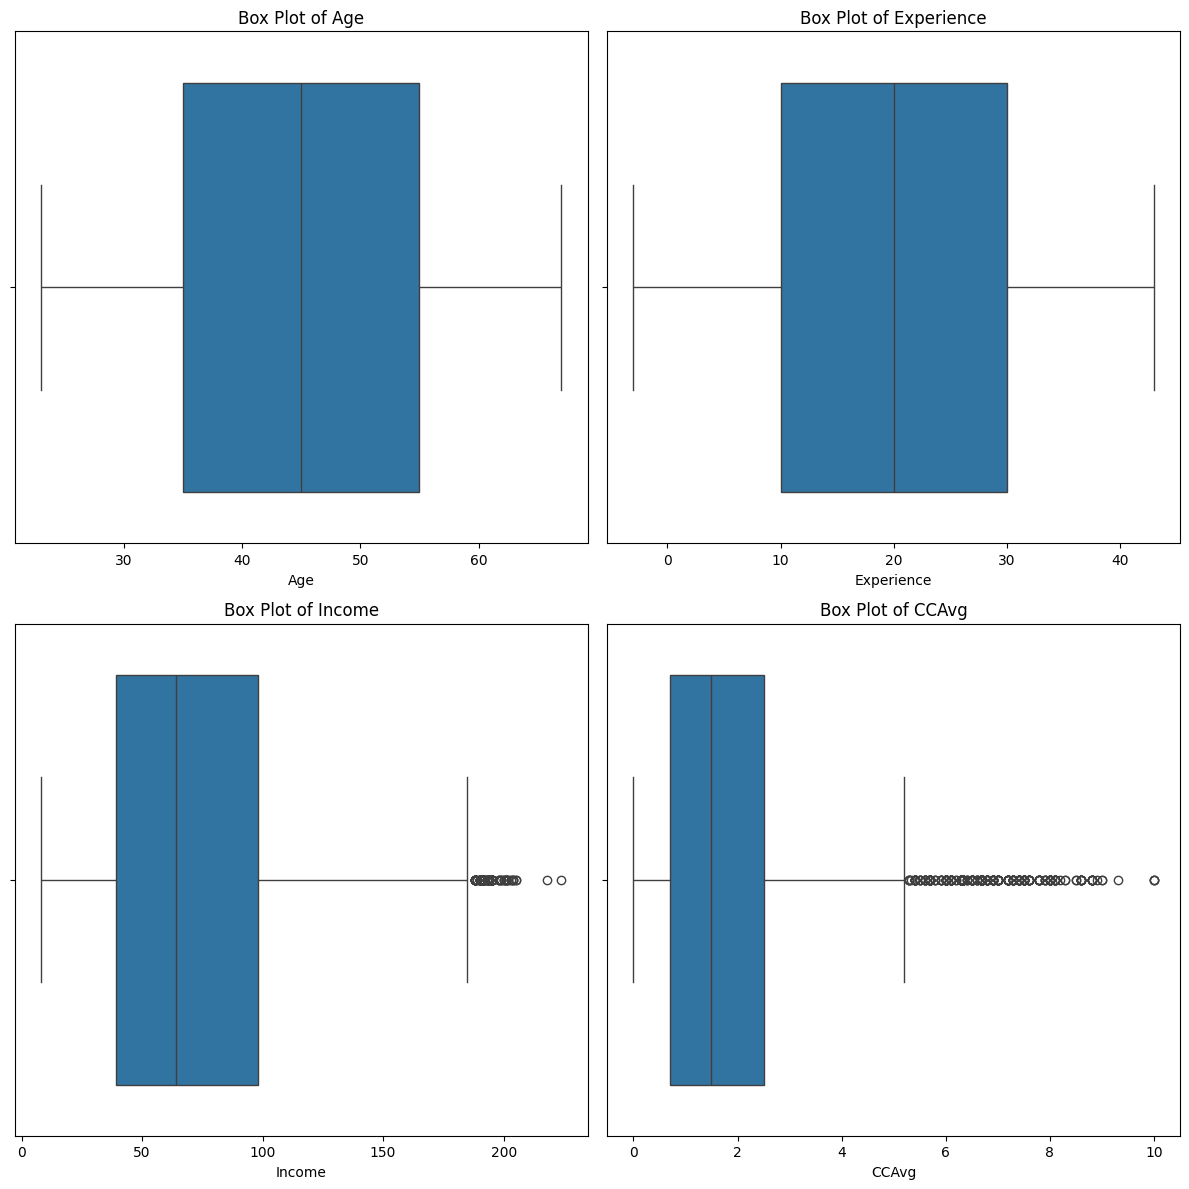

In [116]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.boxplot(data=loan_df, x='Age', ax=axes[0, 0])
axes[0, 0].set_title('Box Plot of Age')

sns.boxplot(data=loan_df, x='Experience', ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Experience')

sns.boxplot(data=loan_df, x='Income', ax=axes[1, 0])
axes[1, 0].set_title('Box Plot of Income')

sns.boxplot(data=loan_df, x='CCAvg', ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of CCAvg')

plt.savefig('plots/boxplots.png')
plt.tight_layout()
plt.show()

##### Distribution and scatter plot of Income and CC Avg hued by Personal Loan, features that are correlated with Personal Loan


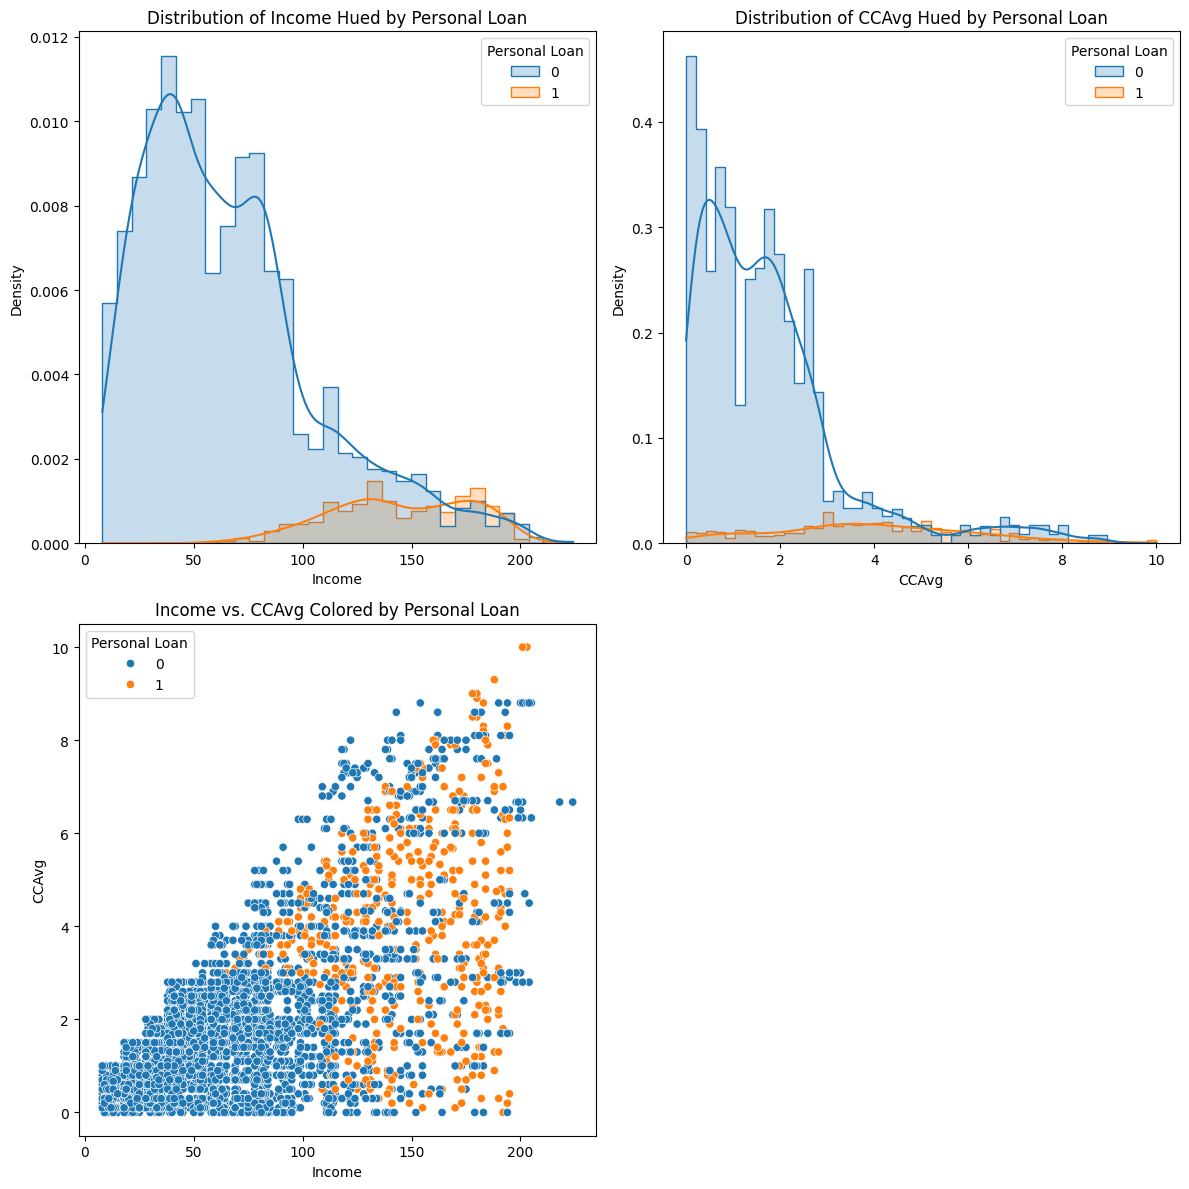

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.histplot(data=loan_df, x='Income', hue='Personal Loan', kde=True, element='step', stat='density', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Income Hued by Personal Loan')

sns.histplot(data=loan_df, x='CCAvg', hue='Personal Loan', kde=True, element='step', stat='density', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of CCAvg Hued by Personal Loan')

sns.scatterplot(data=loan_df, x='Income', y='CCAvg', hue='Personal Loan', ax=axes[1, 0])
axes[1, 0].set_title('Income vs. CCAvg Colored by Personal Loan')

axes[1, 1].set_visible(False)

plt.tight_layout()

plt.savefig('plots/income_ccavg_distribution.png') 
plt.show()


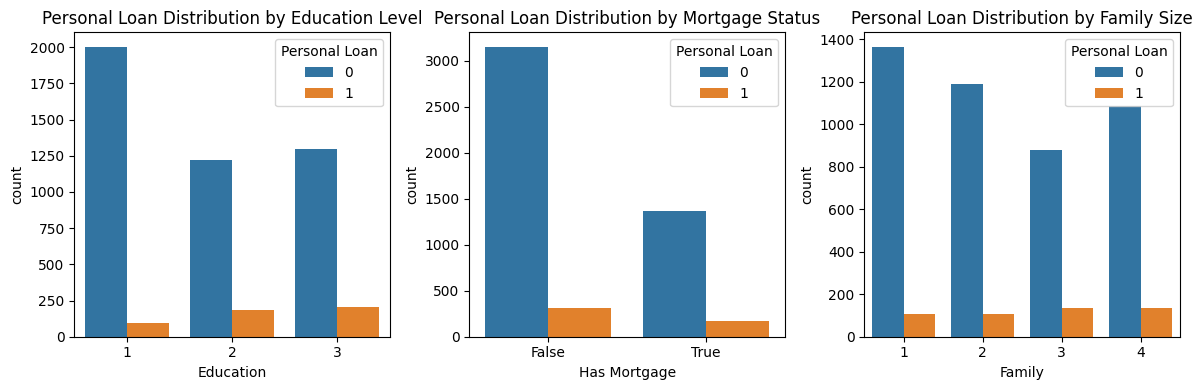

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.countplot(x='Education', hue='Personal Loan', data=loan_df, ax=axes[0])
axes[0].set_title('Personal Loan Distribution by Education Level')

sns.countplot(x='Has Mortgage', hue='Personal Loan', data=loan_df, ax=axes[1])
axes[1].set_title('Personal Loan Distribution by Mortgage Status')

sns.countplot(x='Family', hue='Personal Loan', data=loan_df, ax=axes[2])
axes[2].set_title('Personal Loan Distribution by Family Size')

plt.savefig('plots/education_has_mortgage_family_categorical_distributions.png')

plt.tight_layout()
plt.show()


## Preprocessing


In [91]:
nan_counts = loan_df.isna().sum()
print(list(nan_counts))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


There is no NaN or None values in the dataset, therefore no special handling of this needs to be done.


Categorical values like education are already encoded to numerical values, no special handling for that is needed.


ZIP code is numerical, but it is more categorical by nature, it could be useful to differentiate zones, or to classify into urban, suburban and rural, but higher or lower numerically ZIP code does not mean anything, since I could not find good dataset to split into urban suburban and rural, ZIP code column will be dropped for most things.


Since there is no NaN or missing values, and everything is converted to numerical, MinMaxScaler is enough for most preprocessing.


In [32]:
%%writefile transformers/preprocessor.py

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, add_polynomial_features=False, degree=2):
        self.scaler = MinMaxScaler()
        self.add_polynomial_features = add_polynomial_features
        self.degree = degree
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=False) if self.add_polynomial_features else None

    def fit(self, X, y=None):
        X_scaled = self.scaler.fit_transform(X)

        if self.add_polynomial_features:
            self.poly.fit(X_scaled)

        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)

        if self.add_polynomial_features:
            X_scaled = self.poly.transform(X_scaled)

        return X_scaled

Overwriting transformers/preprocessor.py


In [2]:
numerical_column_names = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
categorical_column_names = ['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard', 'Has Mortgage']

### Split into train and test


In [18]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(loan_df, test_size=0.2, random_state=1)

train_df.to_csv('data/train.csv', index=False)
test_df.to_csv('data/test.csv', index=False)

In [119]:
dataset_description = {
    'name': 'Bank Personal Loan Modelling, Train data',
    'url': 'https://www.kaggle.com/itsmesunil/bank-loan-modelling',
    'description': 'Train data of the Bank Personal Loan Modelling dataset.',
    'row_count': train_df.shape[0],
    'column_count': train_df.shape[1],
    'columns': train_df.columns.tolist(),
    'target_column': 'Personal Loan',
}

with open('data/train.description.yaml', 'w') as file:
    yaml.dump(dataset_description, file, sort_keys=False)

dataset_description

{'name': 'Bank Personal Loan Modelling, Train data',
 'url': 'https://www.kaggle.com/itsmesunil/bank-loan-modelling',
 'description': 'Train data of the Bank Personal Loan Modelling dataset.',
 'row_count': 4000,
 'column_count': 14,
 'columns': ['Age',
  'Experience',
  'Income',
  'ZIP Code',
  'Family',
  'CCAvg',
  'Education',
  'Mortgage',
  'Personal Loan',
  'Securities Account',
  'CD Account',
  'Online',
  'CreditCard',
  'Has Mortgage'],
 'target_column': 'Personal Loan'}

In [120]:
dataset_description = {
    'name': 'Bank Personal Loan Modelling, Test data',
    'url': 'https://www.kaggle.com/itsmesunil/bank-loan-modelling',
    'description': 'Test data of the Bank Personal Loan Modelling dataset.',
    'row_count': test_df.shape[0],
    'column_count': test_df.shape[1],
    'columns': test_df.columns.tolist(),
    'target_column': 'Personal Loan',
}

with open('data/test.description.yaml', 'w') as file:
    yaml.dump(dataset_description, file, sort_keys=False)

dataset_description

{'name': 'Bank Personal Loan Modelling, Test data',
 'url': 'https://www.kaggle.com/itsmesunil/bank-loan-modelling',
 'description': 'Test data of the Bank Personal Loan Modelling dataset.',
 'row_count': 1000,
 'column_count': 14,
 'columns': ['Age',
  'Experience',
  'Income',
  'ZIP Code',
  'Family',
  'CCAvg',
  'Education',
  'Mortgage',
  'Personal Loan',
  'Securities Account',
  'CD Account',
  'Online',
  'CreditCard',
  'Has Mortgage'],
 'target_column': 'Personal Loan'}

### Balancing the train dataset

Since the dataset is unbalanced (most people did not take a Personal Loan), the train dataset should be balanced, the two following methods will be tried:

- Oversampling using SMOTE

- Dropping data from the most frequent class


#### Oversampled dataset using SMOTE


In [40]:
from imblearn.over_sampling import SMOTE

X_train = train_df.drop('Personal Loan', axis=1)
y_train = train_df['Personal Loan']

smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

oversampled_train_df = pd.concat([X_train_oversampled, y_train_oversampled], axis=1)

oversampled_train_df.to_csv('data/train_oversampled.csv', index=False)

dataset_description = {
    'name': 'Bank Personal Loan Modelling, Oversampled Train data',
    'url': 'https://www.kaggle.com/itsmesunil/bank-loan-modelling',
    'description': 'Oversampled Train data of the Bank Personal Loan Modelling dataset.',
    'row_count': oversampled_train_df.shape[0],
    'column_count': oversampled_train_df.shape[1],
    'columns': oversampled_train_df.columns.tolist(),
    'target_column': 'Personal Loan',
}

with open('data/train_oversampled.description.yaml', 'w') as file:
    yaml.dump(dataset_description, file, sort_keys=False)

#### Reduced dataset dropping values from the most frequent class


In [43]:
class_counts = train_df['Personal Loan'].value_counts()

dominant_class = class_counts.idxmax()

minority_class = class_counts.idxmin()

class_difference = class_counts[dominant_class] - class_counts[minority_class]

dominant_class_indices = train_df[train_df['Personal Loan'] == dominant_class].index

drop_indices = np.random.choice(dominant_class_indices, size=class_difference, replace=False)

reduced_train_df = train_df.drop(drop_indices)

reduced_class_counts = reduced_train_df['Personal Loan'].value_counts()
assert reduced_class_counts[dominant_class] == reduced_class_counts[minority_class]

reduced_train_df.to_csv('data/train_reduced.csv', index=False)

dataset_description = {
    'name': 'Bank Personal Loan Modelling, Reduced Train data',
    'url': 'https://www.kaggle.com/itsmesunil/bank-loan-modelling',
    'description': 'Reduced Train data of the Bank Personal Loan Modelling dataset.',
    'row_count': reduced_train_df.shape[0],
    'column_count': reduced_train_df.shape[1],
    'columns': reduced_train_df.columns.tolist(),
    'target_column': 'Personal Loan',
}

with open('data/train_reduced.description.yaml', 'w') as file:
    yaml.dump(dataset_description, file, sort_keys=False)

## Classifiers


### Logistic regression classifier


In [27]:
%%writefile classifiers/logistic_regression.py

import yaml
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from transformers.preprocessor import Preprocessor
from sklearn.base import BaseEstimator

class LogisticRegressionClassifier(BaseEstimator):
    def __init__(self, preprocessor_params={}, logistic_regression_params={}):
        self.preprocessor_params = preprocessor_params
        self.logistic_regression_params = logistic_regression_params
        self.preprocessor = Preprocessor(**self.preprocessor_params)
        self.model = LogisticRegression(**self.logistic_regression_params)

    def fit(self, X, y):
        self.pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('logistic_regression', self.model)
        ])
        self.pipeline.fit(X, y)

    def predict(self, X):
        return self.pipeline.predict(X)

    def get_params(self, deep=True):
        return {"preprocessor_params": self.preprocessor_params,
                "logistic_regression_params": self.logistic_regression_params}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
            
        self.preprocessor = Preprocessor(**self.preprocessor_params)
        self.model = LogisticRegression(**self.logistic_regression_params)
        return self

Overwriting classifiers/logistic_regression.py


### XGBoost classifier


In [90]:
%%writefile classifiers/xgboost_classifier.py

import yaml
import pandas as pd
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from transformers.preprocessor import Preprocessor
from sklearn.base import BaseEstimator

class XGBoostClassifier(BaseEstimator):
    def __init__(self, preprocessor_params={}, xgboost_params={}):
        self.preprocessor_params = preprocessor_params
        self.xgboost_params = xgboost_params
        self.preprocessor = Preprocessor(**self.preprocessor_params)
        self.model = XGBClassifier(**self.xgboost_params)

    def fit(self, X, y):
        self.pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('xgboost', self.model)
        ])
        self.pipeline.fit(X, y)

    def predict(self, X):
        return self.pipeline.predict(X)

    def get_params(self, deep=True):
        return {"preprocessor_params": self.preprocessor_params,
                "xgboost_params": self.xgboost_params}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        
        self.preprocessor = Preprocessor(**self.preprocessor_params)
        self.model = XGBClassifier(**self.xgboost_params)
        return self

Writing classifiers/xgboost_classifier.py


#### KNN Classifier


In [147]:
%%writefile classifiers/knn_classifier.py

import yaml
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from transformers.preprocessor import Preprocessor
from sklearn.base import BaseEstimator

class KNNClassifier(BaseEstimator):
    def __init__(self, preprocessor_params={}, knn_params={}):
        self.preprocessor_params = preprocessor_params
        self.knn_params = knn_params
        self.preprocessor = Preprocessor(**self.preprocessor_params)
        self.model = KNeighborsClassifier(**self.knn_params)

    def fit(self, X, y):
        self.pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('knn', self.model)
        ])
        self.pipeline.fit(X, y)

    def predict(self, X):
        return self.pipeline.predict(X)

    def get_params(self, deep=True):
        return {"preprocessor_params": self.preprocessor_params,
                "knn_params": self.knn_params}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        
        self.preprocessor = Preprocessor(**self.preprocessor_params)
        self.model = KNeighborsClassifier(**self.knn_params)
        return self

Writing classifiers/knn_classifier.py


In [11]:
%%writefile classifiers/random_forest_classifier.py

import yaml
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifierDefault
from sklearn.pipeline import Pipeline
from transformers.preprocessor import Preprocessor
from sklearn.base import BaseEstimator

class RandomForestClassifier(BaseEstimator):
    def __init__(self, preprocessor_params={}, random_forest_params={}):
        self.preprocessor_params = preprocessor_params
        self.random_forest_params = random_forest_params
        self.preprocessor = Preprocessor(**self.preprocessor_params)
        self.model = RandomForestClassifierDefault(**self.random_forest_params)

    def fit(self, X, y):
        self.pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('random_forest', self.model)
        ])
        self.pipeline.fit(X, y)

    def predict(self, X):
        return self.pipeline.predict(X)

    def get_params(self, deep=True):
        return {"preprocessor_params": self.preprocessor_params,
                "random_forest_params": self.random_forest_params}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        
        self.preprocessor = Preprocessor(**self.preprocessor_params)
        self.model = RandomForestClassifierDefault(**self.random_forest_params)
        return self

Overwriting classifiers/random_forest_classifier.py


## Predictions


In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

oversampled_train_df = pd.read_csv('data/train_oversampled.csv')
reduced_train_df = pd.read_csv('data/train_reduced.csv')

columns_to_drop = ['ZIP Code', 'Has Mortgage', 'Personal Loan']

X_train = train_df.drop(columns_to_drop, axis=1)
y_train = train_df['Personal Loan']

X_test = test_df.drop(columns_to_drop, axis=1)
y_test = test_df['Personal Loan']

X_train_oversampled = oversampled_train_df.drop(columns_to_drop, axis=1)
y_train_oversampled = oversampled_train_df['Personal Loan']

X_train_reduced = reduced_train_df.drop(columns_to_drop, axis=1)
y_train_reduced = reduced_train_df['Personal Loan']

### Logistic regression


#### Defining grid search params to brute force parameters


In [119]:
from classifiers import logistic_regression
reload(logistic_regression)

param_grid = {
    'preprocessor_params': [
        {'add_polynomial_features': True, 'degree': degree} 
        for degree in [2, 3, 4]
    ] + [{'add_polynomial_features': False}],
    'logistic_regression_params': [
        {'C': C, 'max_iter': max_iter, 'solver': solver} 
        for C in [0.1, 1.0, 10.0]
        for max_iter in [500]
        for solver in ['liblinear', 'lbfgs']
    ]
}

clf = logistic_regression.LogisticRegressionClassifier()

#### Logistic regression prediction trained with oversampled data


In [107]:
grid_search_oversampled = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search_oversampled.fit(X_train_oversampled, y_train_oversampled)

y_pred_oversampled = grid_search_oversampled.predict(X_test)

results_oversampled = {
    'description': 'Logistic Regression Classifier, trained on oversampled data',
    'best_params': grid_search_oversampled.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_oversampled)),
    'recall': float(recall_score(y_test, y_pred_oversampled)),
    'precision': float(precision_score(y_test, y_pred_oversampled)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_oversampled).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_oversampled)),
}

with open('experiments/results/exp_1_logistic_regression_oversampled.yaml', 'w') as file:
    yaml.dump(results_oversampled, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)
print("Results training with oversampled data:")
pp.pprint(results_oversampled)

Results training with oversampled data:
{   'accuracy': 0.947,
    'best_params': {   'logistic_regression_params': {   'C': 10.0,
                                                         'max_iter': 500,
                                                         'solver': 'liblinear'},
                       'preprocessor_params': {   'add_polynomial_features': True,
                                                  'degree': 4}},
    'confusion_matrix': [[863, 37], [16, 84]],
    'description': 'Logistic Regression Classifier, trained on oversampled '
                   'data',
    'f1_score': 0.7601809954751132,
    'precision': 0.6942148760330579,
    'recall': 0.84}


#### Logistic regression prediction trained with reduced data


In [108]:
grid_search_reduced = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search_reduced.fit(X_train_reduced, y_train_reduced)

y_pred_reduced = grid_search_reduced.predict(X_test)

results_reduced = {
    'description': 'Logistic Regression Classifier, trained on reduced data',
    'best_params': grid_search_reduced.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_reduced)),
    'recall': float(recall_score(y_test, y_pred_reduced)),
    'precision': float(precision_score(y_test, y_pred_reduced)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_reduced).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_reduced)),
}

with open('experiments/results/exp_2_logistic_regression_reduced.yaml', 'w') as file:
    yaml.dump(results_reduced, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)

print("\nResults training with reduced data:")
pp.pprint(results_reduced)


Results training with reduced data:
{   'accuracy': 0.96,
    'best_params': {   'logistic_regression_params': {   'C': 10.0,
                                                         'max_iter': 500,
                                                         'solver': 'liblinear'},
                       'preprocessor_params': {   'add_polynomial_features': True,
                                                  'degree': 4}},
    'confusion_matrix': [[868, 32], [8, 92]],
    'description': 'Logistic Regression Classifier, trained on reduced data',
    'f1_score': 0.8214285714285714,
    'precision': 0.7419354838709677,
    'recall': 0.92}


#### Logistic regression prediction trained with original data


In [120]:
grid_search_reduced = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search_reduced.fit(X_train, y_train)

y_pred_reduced = grid_search_reduced.predict(X_test)

results_original = {
    'description': 'Logistic Regression Classifier, trained on original data',
    'best_params': grid_search_reduced.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_reduced)),
    'recall': float(recall_score(y_test, y_pred_reduced)),
    'precision': float(precision_score(y_test, y_pred_reduced)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_reduced).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_reduced)),
}

with open('experiments/results/exp_3_logistic_regression_original.yaml', 'w') as file:
    yaml.dump(results_original, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)

print("\nResults training with original data:")
pp.pprint(results_original)


Results training with original data:
{   'accuracy': 0.977,
    'best_params': {   'logistic_regression_params': {   'C': 10.0,
                                                         'max_iter': 500,
                                                         'solver': 'liblinear'},
                       'preprocessor_params': {   'add_polynomial_features': True,
                                                  'degree': 4}},
    'confusion_matrix': [[897, 3], [20, 80]],
    'description': 'Logistic Regression Classifier, trained on original data',
    'f1_score': 0.8743169398907104,
    'precision': 0.963855421686747,
    'recall': 0.8}


### Performance metrics over iterations of Logistic Regression Classifier

Over train with reduced dataset.


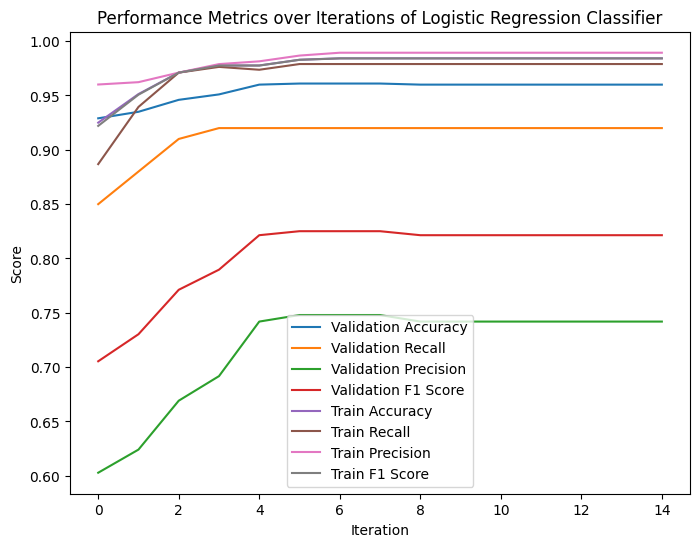

In [121]:
from transformers import preprocessor
reload(preprocessor)

warnings.filterwarnings("ignore", category=ConvergenceWarning)

with open('experiments/results/exp_2_logistic_regression_reduced.yaml', 'r') as file:
    best_params = yaml.safe_load(file)['best_params']

preprocessor = preprocessor.Preprocessor(**best_params.get('preprocessor_params', {}))

preprocessed_X_train_reduced = preprocessor.fit_transform(X_train_reduced)

preprocessed_X_test = preprocessor.transform(X_test)

clf_iter = LogisticRegression(**best_params.get('logistic_regression_params', {}), warm_start=True)

metrics = {'accuracy': [], 'recall': [], 'precision': [], 'f1': []}
train_metrics = {'accuracy': [], 'recall': [], 'precision': [], 'f1': []}

for i in range(1, 16):
    clf_iter.set_params(max_iter=i)
    clf_iter.fit(preprocessed_X_train_reduced, y_train_reduced)

    y_train_reduced_pred_iter = clf_iter.predict(preprocessed_X_train_reduced)

    train_metrics['accuracy'].append(accuracy_score(y_train_reduced, y_train_reduced_pred_iter))
    train_metrics['recall'].append(recall_score(y_train_reduced, y_train_reduced_pred_iter))
    train_metrics['precision'].append(precision_score(y_train_reduced, y_train_reduced_pred_iter))
    train_metrics['f1'].append(f1_score(y_train_reduced, y_train_reduced_pred_iter))

    y_pred_iter = clf_iter.predict(preprocessed_X_test)

    metrics['accuracy'].append(accuracy_score(y_test, y_pred_iter))
    metrics['recall'].append(recall_score(y_test, y_pred_iter))
    metrics['precision'].append(precision_score(y_test, y_pred_iter))
    metrics['f1'].append(f1_score(y_test, y_pred_iter))

plt.figure(figsize=(8, 6))
plt.plot(metrics['accuracy'], label='Validation Accuracy')
plt.plot(metrics['recall'], label='Validation Recall')
plt.plot(metrics['precision'], label='Validation Precision')
plt.plot(metrics['f1'], label='Validation F1 Score')
plt.plot(train_metrics['accuracy'], label='Train Accuracy')
plt.plot(train_metrics['recall'], label='Train Recall')
plt.plot(train_metrics['precision'], label='Train Precision')
plt.plot(train_metrics['f1'], label='Train F1 Score')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Performance Metrics over Iterations of Logistic Regression Classifier')
plt.legend()

plt.savefig('plots/logistic_regression_convergence_reduced.png')
plt.show()

Over train with original dataset


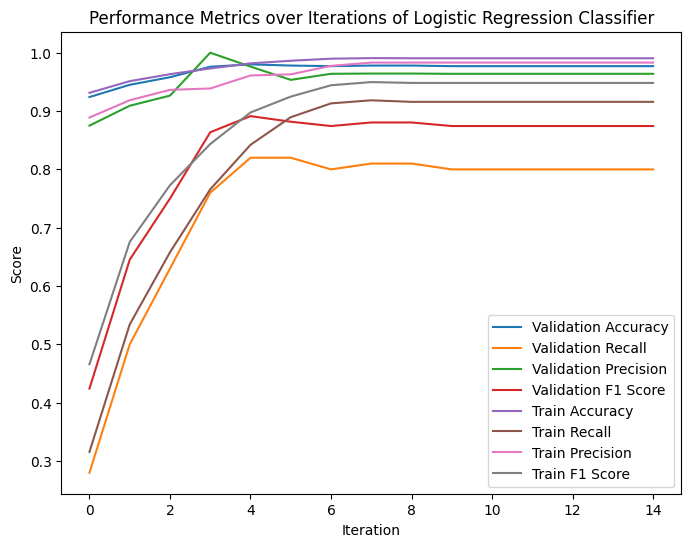

In [122]:
from transformers import preprocessor
reload(preprocessor)

warnings.filterwarnings("ignore", category=ConvergenceWarning)

with open('experiments/results/exp_3_logistic_regression_original.yaml', 'r') as file:
    best_params = yaml.safe_load(file)['best_params']

preprocessor = preprocessor.Preprocessor(**best_params.get('preprocessor_params', {}))

preprocessed_X_train = preprocessor.fit_transform(X_train)

preprocessed_X_test = preprocessor.transform(X_test)

clf_iter = LogisticRegression(**best_params.get('logistic_regression_params', {}), warm_start=True)

metrics = {'accuracy': [], 'recall': [], 'precision': [], 'f1': []}
train_metrics = {'accuracy': [], 'recall': [], 'precision': [], 'f1': []}

for i in range(1, 16):
    clf_iter.set_params(max_iter=i)
    clf_iter.fit(preprocessed_X_train, y_train)

    y_train_pred_iter = clf_iter.predict(preprocessed_X_train)

    train_metrics['accuracy'].append(accuracy_score(y_train, y_train_pred_iter))
    train_metrics['recall'].append(recall_score(y_train, y_train_pred_iter))
    train_metrics['precision'].append(precision_score(y_train, y_train_pred_iter))
    train_metrics['f1'].append(f1_score(y_train, y_train_pred_iter))

    y_pred_iter = clf_iter.predict(preprocessed_X_test)

    metrics['accuracy'].append(accuracy_score(y_test, y_pred_iter))
    metrics['recall'].append(recall_score(y_test, y_pred_iter))
    metrics['precision'].append(precision_score(y_test, y_pred_iter))
    metrics['f1'].append(f1_score(y_test, y_pred_iter))

plt.figure(figsize=(8, 6))
plt.plot(metrics['accuracy'], label='Validation Accuracy')
plt.plot(metrics['recall'], label='Validation Recall')
plt.plot(metrics['precision'], label='Validation Precision')
plt.plot(metrics['f1'], label='Validation F1 Score')
plt.plot(train_metrics['accuracy'], label='Train Accuracy')
plt.plot(train_metrics['recall'], label='Train Recall')
plt.plot(train_metrics['precision'], label='Train Precision')
plt.plot(train_metrics['f1'], label='Train F1 Score')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Performance Metrics over Iterations of Logistic Regression Classifier')
plt.legend()

plt.savefig('plots/logistic_regression_convergence_original.png')
plt.show()

### XGBoost


In [128]:
from classifiers import xgboost_classifier
reload(xgboost_classifier)

param_grid = {
    'preprocessor_params': [
        {'add_polynomial_features': True, 'degree': degree} 
        for degree in [2]
    ] + [{'add_polynomial_features': False}],
    'xgboost_params': [
        {'learning_rate': lr, 'n_estimators': n_estimators, 'max_depth': max_depth, 
         'min_child_weight': min_child_weight}
        for lr in [0.01, 0.1, 0.2]
        for n_estimators in [50, 100]
        for max_depth in [3, 6]
        for min_child_weight in [1, 3, 5]
    ]
}

xgb_clf = xgboost_classifier.XGBoostClassifier()

#### XGBoost prediction with oversampled data


In [129]:
grid_search_oversampled = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy')
grid_search_oversampled.fit(X_train_oversampled, y_train_oversampled)

y_pred_oversampled = grid_search_oversampled.predict(X_test)

results_oversampled = {
    'description': 'XGBoost Classifier, trained on oversampled data',
    'best_params': grid_search_oversampled.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_oversampled)),
    'recall': float(recall_score(y_test, y_pred_oversampled)),
    'precision': float(precision_score(y_test, y_pred_oversampled)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_oversampled).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_oversampled)),
}

with open('experiments/results/exp_4_xgboost_oversampled.yaml', 'w') as file:
    yaml.dump(results_oversampled, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)
print("Results training with oversampled data:")
pp.pprint(results_oversampled)

Results training with oversampled data:
{   'accuracy': 0.97,
    'best_params': {   'preprocessor_params': {   'add_polynomial_features': False},
                       'xgboost_params': {   'learning_rate': 0.2,
                                             'max_depth': 6,
                                             'min_child_weight': 1,
                                             'n_estimators': 100}},
    'confusion_matrix': [[879, 21], [9, 91]],
    'description': 'XGBoost Classifier, trained on oversampled data',
    'f1_score': 0.8584905660377358,
    'precision': 0.8125,
    'recall': 0.91}


#### XGBoost prediction with reduced data


In [130]:
grid_search_reduced = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy')
grid_search_reduced.fit(X_train_reduced, y_train_reduced)

y_pred_reduced = grid_search_reduced.predict(X_test)

results_reduced = {
    'description': 'XGBoost Classifier, trained on reduced data',
    'best_params': grid_search_reduced.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_reduced)),
    'recall': float(recall_score(y_test, y_pred_reduced)),
    'precision': float(precision_score(y_test, y_pred_reduced)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_reduced).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_reduced)),
}

with open('experiments/results/exp_5_xgboost_reduced.yaml', 'w') as file:
    yaml.dump(results_reduced, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)
print("Results training with reduced data:")
pp.pprint(results_reduced)

Results training with reduced data:
{   'accuracy': 0.963,
    'best_params': {   'preprocessor_params': {   'add_polynomial_features': False},
                       'xgboost_params': {   'learning_rate': 0.1,
                                             'max_depth': 6,
                                             'min_child_weight': 1,
                                             'n_estimators': 100}},
    'confusion_matrix': [[867, 33], [4, 96]],
    'description': 'XGBoost Classifier, trained on reduced data',
    'f1_score': 0.8384279475982533,
    'precision': 0.7441860465116279,
    'recall': 0.96}


#### XGBoost prediction with original data


In [145]:
grid_search_original = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='f1')
grid_search_original.fit(X_train, y_train)

y_pred_original = grid_search_original.predict(X_test)

results_original = {
    'description': 'XGBoost Classifier, trained on original data',
    'best_params': grid_search_original.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_original)),
    'recall': float(recall_score(y_test, y_pred_original)),
    'precision': float(precision_score(y_test, y_pred_original)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_original).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_original)),
}

with open('experiments/results/exp_6_xgboost_original.yaml', 'w') as file:
    yaml.dump(results_original, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)
print("Results training with reduced data:")
pp.pprint(results_original)

Results training with reduced data:
{   'accuracy': 0.984,
    'best_params': {   'preprocessor_params': {   'add_polynomial_features': False},
                       'xgboost_params': {   'learning_rate': 0.2,
                                             'max_depth': 3,
                                             'min_child_weight': 1,
                                             'n_estimators': 100}},
    'confusion_matrix': [[895, 5], [11, 89]],
    'description': 'XGBoost Classifier, trained on original data',
    'f1_score': 0.9175257731958764,
    'precision': 0.9468085106382979,
    'recall': 0.89}


### XGBoost performance over number of estimators

Trained over original dataset


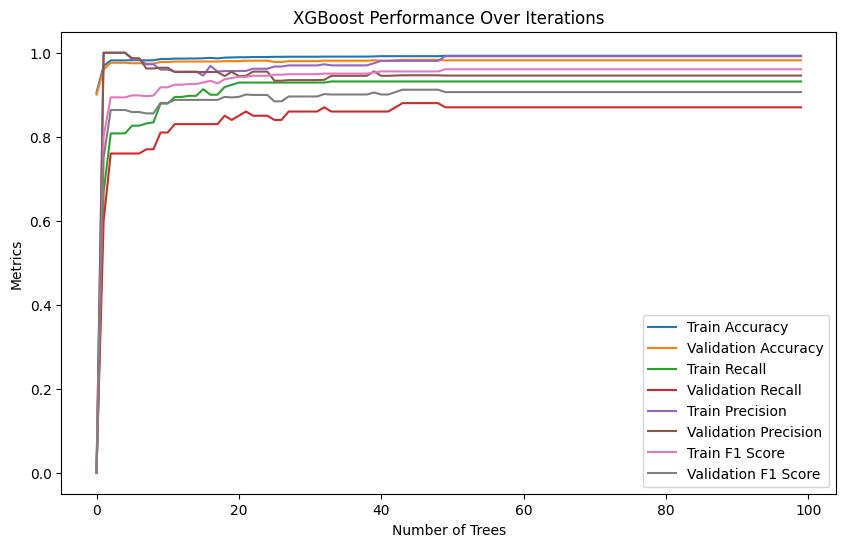

In [146]:
from transformers import preprocessor
reload(preprocessor)

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

with open('experiments/results/exp_6_xgboost_original.yaml', 'r') as file:
    results = yaml.safe_load(file)

best_params = results['best_params']

preprocessor = preprocessor.Preprocessor(**best_params.get('preprocessor_params', {}))

preprocessed_X_train = preprocessor.fit_transform(X_train)

preprocessed_X_test = preprocessor.transform(X_test)

xgb_clf_iter = XGBClassifier(**best_params.get('xgboost_params', {}), early_stopping_rounds=10)
eval_set = [(preprocessed_X_train, y_train), (preprocessed_X_test, y_test)]
xgb_clf_iter.fit(preprocessed_X_train, y_train, eval_set=eval_set, verbose=False)
rounds = best_params.get('xgboost_params', {}).get('n_estimators')

metrics = {'train_accuracy': [], 'val_accuracy': [],
           'train_recall': [], 'val_recall': [],
           'train_precision': [], 'val_precision': [],
           'train_f1': [], 'val_f1': []}

for i in range(1, rounds + 1):
    xgb_clf_iter.set_params(n_estimators=i)
    xgb_clf_iter.fit(preprocessed_X_train, y_train, eval_set=eval_set, verbose=False)

    y_train_pred = xgb_clf_iter.predict(preprocessed_X_train)
    metrics['train_accuracy'].append(accuracy_score(y_train, y_train_pred))
    metrics['train_recall'].append(recall_score(y_train, y_train_pred))
    metrics['train_precision'].append(precision_score(y_train, y_train_pred))
    metrics['train_f1'].append(f1_score(y_train, y_train_pred))

    y_test_pred = xgb_clf_iter.predict(preprocessed_X_test)
    metrics['val_accuracy'].append(accuracy_score(y_test, y_test_pred))
    metrics['val_recall'].append(recall_score(y_test, y_test_pred))
    metrics['val_precision'].append(precision_score(y_test, y_test_pred))
    metrics['val_f1'].append(f1_score(y_test, y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(metrics['train_accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.plot(metrics['train_recall'], label='Train Recall')
plt.plot(metrics['val_recall'], label='Validation Recall')
plt.plot(metrics['train_precision'], label='Train Precision')
plt.plot(metrics['val_precision'], label='Validation Precision')
plt.plot(metrics['train_f1'], label='Train F1 Score')
plt.plot(metrics['val_f1'], label='Validation F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Metrics')
plt.title('XGBoost Performance Over Iterations')
plt.legend()
plt.savefig('plots/xgboost_convergence_original.png')
plt.show()

### KNN


In [154]:
from classifiers import knn_classifier
reload(knn_classifier)

param_grid = {
    'preprocessor_params': [
        {'add_polynomial_features': True, 'degree': degree} 
        for degree in [2, 3]
    ] + [{'add_polynomial_features': False}],
    'knn_params': [
        {'n_neighbors': n_neighbors, 'metric': metric, 'weights': weights}
        for n_neighbors in [5, 7, 10, 15]
        for metric in ['euclidean', 'manhattan']
        for weights in ['uniform', 'distance']
    ]
}

knn_clf = knn_classifier.KNNClassifier()

#### KNN prediciton with oversampled data


In [155]:
grid_search_oversampled = GridSearchCV(knn_clf, param_grid, cv=5, scoring='f1')
grid_search_oversampled.fit(X_train_oversampled, y_train_oversampled)

y_pred_oversampled = grid_search_oversampled.predict(X_test)

results_oversampled = {
    'description': 'KNN Classifier, trained on oversampled data',
    'best_params': grid_search_oversampled.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_oversampled)),
    'recall': float(recall_score(y_test, y_pred_oversampled)),
    'precision': float(precision_score(y_test, y_pred_oversampled)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_oversampled).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_oversampled)),
}

with open('experiments/results/exp_7_knn_oversampled.yaml', 'w') as file:
    yaml.dump(results_oversampled, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)
print("Results training with oversampled data:")
pp.pprint(results_oversampled)

Results training with oversampled data:
{   'accuracy': 0.938,
    'best_params': {   'knn_params': {   'metric': 'manhattan',
                                         'n_neighbors': 5,
                                         'weights': 'distance'},
                       'preprocessor_params': {   'add_polynomial_features': True,
                                                  'degree': 2}},
    'confusion_matrix': [[853, 47], [15, 85]],
    'description': 'KNN Classifier, trained on oversampled data',
    'f1_score': 0.7327586206896552,
    'precision': 0.6439393939393939,
    'recall': 0.85}


#### KNN prediciton with reduced data


In [157]:
grid_search_reduced = GridSearchCV(knn_clf, param_grid, cv=5, scoring='f1')
grid_search_reduced.fit(X_train_reduced, y_train_reduced)

y_pred_reduced = grid_search_reduced.predict(X_test)

results_reduced = {
    'description': 'KNN Classifier, trained on reduced data',
    'best_params': grid_search_reduced.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_reduced)),
    'recall': float(recall_score(y_test, y_pred_reduced)),
    'precision': float(precision_score(y_test, y_pred_reduced)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_reduced).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_reduced)),
}

with open('experiments/results/exp_8_knn_reduced.yaml', 'w') as file:
    yaml.dump(results_reduced, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)
print("Results training with reduced data:")
pp.pprint(results_reduced)

Results training with reduced data:
{   'accuracy': 0.916,
    'best_params': {   'knn_params': {   'metric': 'manhattan',
                                         'n_neighbors': 7,
                                         'weights': 'distance'},
                       'preprocessor_params': {   'add_polynomial_features': False}},
    'confusion_matrix': [[829, 71], [13, 87]],
    'description': 'KNN Classifier, trained on reduced data',
    'f1_score': 0.6744186046511629,
    'precision': 0.5506329113924051,
    'recall': 0.87}


#### KNN prediction with original data


In [158]:
grid_search_original = GridSearchCV(knn_clf, param_grid, cv=5, scoring='f1')
grid_search_original.fit(X_train, y_train)

y_pred_original = grid_search_original.predict(X_test)

results_original = {
    'description': 'KNN Classifier, trained on original data',
    'best_params': grid_search_original.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_original)),
    'recall': float(recall_score(y_test, y_pred_original)),
    'precision': float(precision_score(y_test, y_pred_original)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_original).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_original)),
}

with open('experiments/results/exp_9_knn_original.yaml', 'w') as file:
    yaml.dump(results_original, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)
print("Results training with original data:")
pp.pprint(results_original)

Results training with original data:
{   'accuracy': 0.958,
    'best_params': {   'knn_params': {   'metric': 'euclidean',
                                         'n_neighbors': 5,
                                         'weights': 'distance'},
                       'preprocessor_params': {   'add_polynomial_features': False}},
    'confusion_matrix': [[897, 3], [39, 61]],
    'description': 'KNN Classifier, trained on original data',
    'f1_score': 0.7439024390243903,
    'precision': 0.953125,
    'recall': 0.61}


### Random forest


In [13]:
from classifiers import random_forest_classifier
reload(random_forest_classifier)

param_grid = {
    'preprocessor_params': [
        {'add_polynomial_features': True, 'degree': degree} 
        for degree in [2]
    ] + [{'add_polynomial_features': False}],
    'random_forest_params': [
        {'n_estimators': n_estimators, 'max_depth': max_depth, 
         'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
        for n_estimators in [60, 100]
        for max_depth in [None, 3, 6]
        for min_samples_split in [2, 5]
        for min_samples_leaf in [1, 2, 4]
    ]
}

rf_clf = random_forest_classifier.RandomForestClassifier()

#### Random forest prediction with oversampled data


In [15]:
grid_search_oversampled = GridSearchCV(rf_clf, param_grid, cv=5, scoring='f1')
grid_search_oversampled.fit(X_train_oversampled, y_train_oversampled)

y_pred_oversampled = grid_search_oversampled.predict(X_test)

results_oversampled = {
    'description': 'Random Forest Classifier, trained on oversampled data',
    'best_params': grid_search_oversampled.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_oversampled)),
    'recall': float(recall_score(y_test, y_pred_oversampled)),
    'precision': float(precision_score(y_test, y_pred_oversampled)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_oversampled).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_oversampled)),
}

with open('experiments/results/exp_10_random_forest_oversampled.yaml', 'w') as file:
    yaml.dump(results_oversampled, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)
print("Results training with oversampled data:")
pp.pprint(results_oversampled)

Results training with oversampled data:
{   'accuracy': 0.968,
    'best_params': {   'preprocessor_params': {   'add_polynomial_features': False},
                       'random_forest_params': {   'max_depth': None,
                                                   'min_samples_leaf': 1,
                                                   'min_samples_split': 2,
                                                   'n_estimators': 100}},
    'confusion_matrix': [[880, 20], [12, 88]],
    'description': 'Random Forest Classifier, trained on oversampled data',
    'f1_score': 0.8461538461538461,
    'precision': 0.8148148148148148,
    'recall': 0.88}


#### Random forest prediction with reduced data


In [14]:
grid_search_reduced = GridSearchCV(rf_clf, param_grid, cv=5, scoring='f1')
grid_search_reduced.fit(X_train_reduced, y_train_reduced)

y_pred_reduced = grid_search_reduced.predict(X_test)

results_reduced = {
    'description': 'Random Forest Classifier, trained on reduced data',
    'best_params': grid_search_reduced.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_reduced)),
    'recall': float(recall_score(y_test, y_pred_reduced)),
    'precision': float(precision_score(y_test, y_pred_reduced)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_reduced).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_reduced)),
}

with open('experiments/results/exp_11_random_forest_reduced.yaml', 'w') as file:
    yaml.dump(results_reduced, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)
print("Results training with reduced data:")
pp.pprint(results_reduced)

Results training with reduced data:
{   'accuracy': 0.965,
    'best_params': {   'preprocessor_params': {   'add_polynomial_features': False},
                       'random_forest_params': {   'max_depth': None,
                                                   'min_samples_leaf': 1,
                                                   'min_samples_split': 2,
                                                   'n_estimators': 100}},
    'confusion_matrix': [[870, 30], [5, 95]],
    'description': 'Random Forest Classifier, trained on reduced data',
    'f1_score': 0.8444444444444444,
    'precision': 0.76,
    'recall': 0.95}


#### Random Forest prediction with original data


In [16]:
grid_search_original = GridSearchCV(rf_clf, param_grid, cv=5, scoring='f1')
grid_search_original.fit(X_train, y_train)

y_pred_original = grid_search_original.predict(X_test)

results_original = {
    'description': 'Random Forest Classifier, trained on original data',
    'best_params': grid_search_original.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_original)),
    'recall': float(recall_score(y_test, y_pred_original)),
    'precision': float(precision_score(y_test, y_pred_original)),
    'confusion_matrix': confusion_matrix(y_test, y_pred_original).tolist(),
    'f1_score': float(f1_score(y_test, y_pred_original)),
}

with open('experiments/results/exp_12_random_forest_original.yaml', 'w') as file:
    yaml.dump(results_original, file, sort_keys=False)

pp = pprint.PrettyPrinter(indent=4)
print("Results training with original data:")
pp.pprint(results_original)

Results training with original data:
{   'accuracy': 0.98,
    'best_params': {   'preprocessor_params': {   'add_polynomial_features': True,
                                                  'degree': 2},
                       'random_forest_params': {   'max_depth': None,
                                                   'min_samples_leaf': 2,
                                                   'min_samples_split': 2,
                                                   'n_estimators': 60}},
    'confusion_matrix': [[898, 2], [18, 82]],
    'description': 'Random Forest Classifier, trained on original data',
    'f1_score': 0.8913043478260869,
    'precision': 0.9761904761904762,
    'recall': 0.82}


#### Random Forest performance over number of estimators
